# Convolutional Autoencoder on MNIST dataset

**Learning Objective**
1. Build an autoencoder architecture (consisting of an encoder and decoder) in Keras
2. Define the loss using the reconstructive error
3. Define a training step for the autoencoder using tf.GradientTape()
4. Train the autoencoder on the MNIST dataset

## Introduction
This notebook demonstrates how to build and train a convolutional autoencoder.

Autoencoders consist of two models: an encoder and a decoder.

<img src="../assets/autoencoder2.png" width="600">

In this notebook we'll build an autoencoder to recreate MNIST digits. This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 100 epochs. The images increasingly resemble hand written digits as the autoencoder learns to reconstruct the original images.

<img src="../assets/autoencoder.gif">

In [45]:
from __future__ import absolute_import, division, print_function

import glob
import imageio
import time
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from IPython import display

In [19]:
np.random.seed(1)
tf.random.set_seed(1)
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 50
LR = 1e-2
EMBED_DIM = 64 # intermediate_dim

In [20]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [21]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [22]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BATCH_SIZE*4)

In [23]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [24]:
def make_encoder(embed_dim):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(embed_dim))
    
    return model

In [25]:
def make_decoder(embed_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(embed_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [26]:
ae_model = tf.keras.models.Sequential([make_encoder(EMBED_DIM), make_decoder(EMBED_DIM)])

In [27]:
def loss(model, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(model(original), original)))
    return reconstruction_error

In [28]:
#autoencoder.compile(loss="mse")
optimizer = tf.keras.optimizers.SGD(lr=LR)

In [29]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=ae_model)

In [30]:
def train_step(images):
    with tf.GradientTape() as tape:
        ae_gradients = tape.gradient(loss(ae_model, images),
                                     ae_model.trainable_variables)
    gradient_variables = zip(ae_gradients, ae_model.trainable_variables)
    
    optimizer.apply_gradients(gradient_variables)

In [31]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        pixels = predictions[i, :, :] * 127.5 + 127.5
        pixels = np.array(pixels, dtype='float')
        pixels = pixels.reshape((28,28))
        plt.imshow(pixels, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [32]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(ae_model,
                                 epoch + 1,
                                 test_images[:16, :, :, :])

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(ae_model,
                             epochs,
                             test_images[:16, :, :, :])

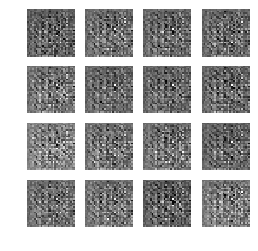

In [33]:
generate_and_save_images(ae_model, 4, test_images[:16, :, :, :])

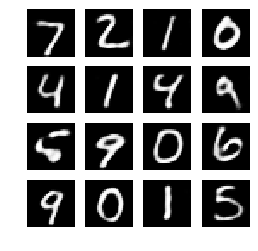

In [34]:
train(train_dataset, EPOCHS)

## Create a GIF

In [37]:
import PIL
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./ae_images/image_at_epoch_{:04d}.png'.format(epoch_no))

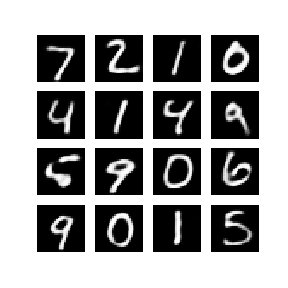

In [43]:
display_image(EPOCHS)

In [47]:
anim_file = 'autoencoder.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./ae_images/image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)